In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split
from datetime import datetime
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random

# Getting the same results with train and train_manual_update
- Write torch.manual_seed(42) at the beginning of your notebook.
- Write torch.set_default_dtype(torch.double) at the beginning of your notebook to alleviate precision errors

In [2]:
torch.manual_seed(42)
torch.set_default_dtype(torch.double)

device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

# Tasks
Load, analyse and preprocess the CIFAR-10 dataset. Split it into 3
datasets: training, validation and test. Take a subset of these datasets
by keeping only 2 labels: cat and car

In [3]:
def load_cifar(train_val_split=0.9, data_path='../data/', preprocessor=None):

    # transformer to resize images to 16x16 pixels
    if preprocessor is None:
        preprocessor = transforms.Compose([
            transforms.Resize(16),
            transforms.ToTensor()
            ])
    
    # load datasets
    train_val_data = datasets.CIFAR10(data_path, train=True, download=True, transform=preprocessor)
    test_data = datasets.CIFAR10(data_path, train=False, download=True, transform=preprocessor)
    
    # sizes of train and validation data
    train_size = int(train_val_split * len(train_val_data))
    val_size = len(train_val_data) - train_size

    # split train_val_data into train and validation sets
    train_data, val_data = random_split(train_val_data, [train_size, val_size])

    # create subsets with only cat (0) and car (1)
    label_map = {3: 0, 1: 1} 

    train = [(img, label_map[label]) for img, label in train_data if label in [1,3]]
    val = [(img, label_map[label]) for img, label in val_data if label in [1,3]]
    test = [(img, label_map[label]) for img, label in test_data if label in [1,3]]

    return train, val, test


def compute_accuracy(model, loader):
    # set the model to evaluation mode
    model.eval()
    correct = 0
    total = 0

    # disable gradient tracking
    with torch.no_grad():
        for images, labels in loader:
            # forward pass
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            # compare predicted with labels
            correct += torch.eq(predicted, labels).sum().item()

    # calculate accuracy
    accuracy = correct / total * 100.0
    return accuracy


## Data analysis

### Load dataset, create loss function and dataloaders

In [4]:
# load datasets
data_train, data_val, data_test = load_cifar()

# loss function
loss_fn = nn.CrossEntropyLoss()

# create dataloaders using train, val and test sets
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


### Visualize images and distribution of the training data

In [5]:
def data_distribution(data, label_names=None):
    # Extract labels from the dataset
    labels = [label for _, label in data]
    
    # Calculate distribution using numpy
    unique_labels, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique_labels, counts))
    
    # Map numeric labels to names if a mapping is provided
    if label_names is not None:
        x_labels = [label_names.get(label, label) for label in unique_labels]
    else:
        x_labels = unique_labels

    # Visualize the label distribution using a bar chart
    plt.figure(figsize=(6, 4))
    plt.bar(x_labels, counts, color='skyblue')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Data Distribution')
    plt.show()
    
    return distribution


def visualize_random_images(data, num_images):
    samples = random.sample(data, num_images)
    # Set up the figure
    plt.figure(figsize=(6, 4))
    
    # Loop over the selected samples
    for i, (img, label) in enumerate(samples):
        plt.subplot(1, num_images, i+1)
        
        # If the image is a tensor, convert it to a numpy array for plotting.
        if torch.is_tensor(img):
            # Convert from (C, H, W) to (H, W, C)
            img = img.permute(1, 2, 0).numpy()
            
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


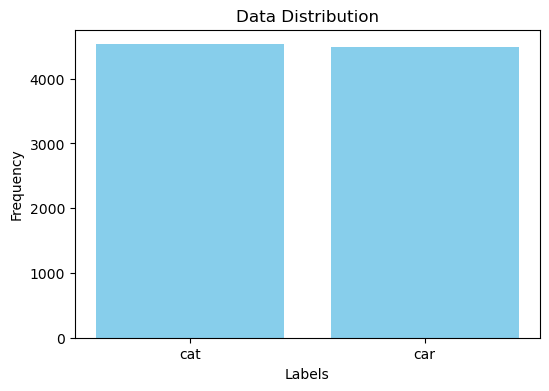

{0: 4529, 1: 4488}


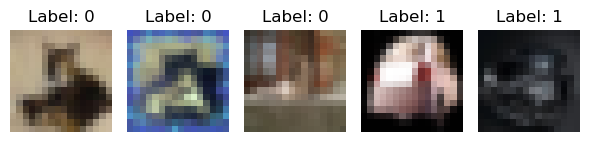

In [6]:
print(data_distribution(data_train, {0: 'cat', 1: 'car'}))
visualize_random_images(data_train, num_images=5)


Write a MyMLP class that implements a MLP in PyTorch (so only fully
connected layers) such that:
    
    - The input dimension is 768(= 16 ∗ 16 ∗ 3) and the output dimension is 2 (for the 2 classes).
    - The hidden layers have respectively 128 and 32 hidden units.
    - All activation functions are ReLU. The last layer has no activation function since the cross-entropy loss already includes a softmax activation
function.

### MyMLP Class

In [7]:
class MyNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(16*16*3, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x

Write a train(n_epochs, optimizer, model, loss_fn, train_loader) function that trains model for n_epochs epochs given an optimizer optimizer, a loss function loss_fn and a dataloader train_loader.

### train()

In [8]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):

    n_batch = len(train_loader)
    train_losses = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            
            imgs.to(device=device, dtype=torch.double) 
            labels = labels.to(device=device)

            outputs = model(imgs)

            # compute the loss
            loss = loss_fn(outputs, labels)

            # compute the gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # zero out all gradients
            optimizer.zero_grad()

            loss_train += loss.item()

        train_losses.append(loss_train / n_batch)

        if epoch == 1 or epoch % 10 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    
    return train_losses


Write a similar function train manual_update that has no optimizer parameter, but a learning rate lr parameter instead and that manually updates each trainable parameter of model using equation (2). Do not forget to zero out all gradients after each iteration. 

Train 2 instances of MyMLP, one using train and the other using train_manual_update (use the same parameter values for both models). Compare their respective training losses. To get exactly the same results with both functions, see section 3.3

### train_manual_update()

In [9]:
def train_manual_update(n_epochs, model, loss_fn, train_loader, lr=1e-2, momentum_coeff=0., weight_decay=0.):
    
    n_batch = len(train_loader)
    train_losses = []
    model.train()
    model.zero_grad()

    # dict for storing velocity values when using momentum
    v = dict()
    
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, label in train_loader:
            
            outputs = model(imgs)
            loss = loss_fn(outputs, label)
            loss.backward()

            # update all parameters
            with torch.no_grad():
                for p in model.parameters():

                    # the gradient value 
                    g_t = p.grad

                    # with weight decay
                    if weight_decay != 0:
                        # update the gradient value using the weight decay
                        g_t += weight_decay * p.data

                    # with momentum
                    if momentum_coeff != 0: 
                        # set initial velocity to gradient for each parameter
                        if p not in v:
                            v[p] = g_t 
                        else:
                            # update the velocity using the momentum, the stored velocity and gradient
                            v[p] = (momentum_coeff * v[p]) + g_t

                        # update the gradient value
                        g_t = v[p]

                    # compute new parameter value
                    p.data -=  lr * g_t

                # zero out the gradients
                model.zero_grad()

                loss_train += loss.item()

        train_losses.append(loss_train / n_batch)

        if epoch == 1 or epoch % 10 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
            
    return train_losses

### Function for comparing training losses

In [10]:
def compare_loss(train_losses, train_manual_losses):
    max_diff = 0
    for tl, tml in zip(train_losses, train_manual_losses):
        if abs(tl-tml) > max_diff:
            max_diff = abs(tl-tml)

    print(f"Max absolute difference between training losses: {max_diff}")

### Function for comparing train() and train_manual_update()

In [11]:
def compare_train_and_manual(train, train_man, added_text="", weight_decay=0., momentum=0.):
    torch.manual_seed(42)
    model = MyNet()

    # creating an optimizer with the given hyperparameters
    optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay = weight_decay, momentum = momentum)

    # Training an instance of MyMLP using train (SGD optimizer)
    print(f"Training using SGD optimizer {added_text}:\n")
    train_losses = train(
        n_epochs = 30,
        optimizer= optimizer, 
        model = model, 
        loss_fn = loss_fn, 
        train_loader = train_loader
    )

    # calculating training and validation accuracy
    a_t = compute_accuracy(model, train_loader)
    a_v = compute_accuracy(model, val_loader)
    print(f"\nTraining accuracy: {a_t}")
    print(f"Validation accuracy: {a_v}")

    print("-"*50)

    torch.manual_seed(42)
    model = MyNet()

    # training an instance of MyMLP using train_manual_update with the given hyperparameters
    print(f"Training using manual update {added_text}:\n")
    train_manual_losses = train_man(
        n_epochs = 30,
        model = model, 
        loss_fn = loss_fn, 
        train_loader = train_loader,
        weight_decay = weight_decay,
        momentum_coeff = momentum
    )

    # calculating training and validation accuracy
    a_t = compute_accuracy(model, train_loader)
    a_v = compute_accuracy(model, val_loader)
    print(f"\nTraining accuracy: {a_t}")
    print(f"Validation accuracy: {a_v}")

    print("-"*50)

    # comparing the loss between the two methods
    compare_loss(train_losses, train_manual_losses)

### (5) Training two models using train and train_manual_update and comparing

In [12]:
compare_train_and_manual(train, train_manual_update)

Training using SGD optimizer :

09:58:27.374939  |  Epoch 1  |  Training loss 0.683
09:58:27.992576  |  Epoch 10  |  Training loss 0.445
09:58:28.586323  |  Epoch 20  |  Training loss 0.349
09:58:29.248479  |  Epoch 30  |  Training loss 0.285

Training accuracy: 87.63446822668294
Validation accuracy: 85.96134282807732
--------------------------------------------------
Training using manual update :

09:58:29.348594  |  Epoch 1  |  Training loss 0.683
09:58:29.918224  |  Epoch 10  |  Training loss 0.445
09:58:30.569927  |  Epoch 20  |  Training loss 0.349
09:58:31.229317  |  Epoch 30  |  Training loss 0.285

Training accuracy: 87.63446822668294
Validation accuracy: 85.96134282807732
--------------------------------------------------
Max absolute difference between training losses: 2.220446049250313e-16


### (6) Training two models using train and train_manual_update with L2 regularization and comparing

In [13]:
compare_train_and_manual(train, train_manual_update, "with weight decay", weight_decay=0.001)

Training using SGD optimizer with weight decay:

09:58:31.337014  |  Epoch 1  |  Training loss 0.683
09:58:31.953654  |  Epoch 10  |  Training loss 0.446
09:58:32.631663  |  Epoch 20  |  Training loss 0.351
09:58:33.312115  |  Epoch 30  |  Training loss 0.288

Training accuracy: 87.54574692247976
Validation accuracy: 86.46998982706002
--------------------------------------------------
Training using manual update with weight decay:

09:58:33.411335  |  Epoch 1  |  Training loss 0.683
09:58:34.061102  |  Epoch 10  |  Training loss 0.446
09:58:34.760847  |  Epoch 20  |  Training loss 0.351
09:58:35.439381  |  Epoch 30  |  Training loss 0.288

Training accuracy: 87.54574692247976
Validation accuracy: 86.46998982706002
--------------------------------------------------
Max absolute difference between training losses: 1.1102230246251565e-16


### (7) Training two models using train and train_manual_update with momentum and comparing

In [14]:
compare_train_and_manual(train, train_manual_update, "with momentum", momentum=0.9)

Training using SGD optimizer with momentum:

09:58:35.610922  |  Epoch 1  |  Training loss 0.573
09:58:36.219740  |  Epoch 10  |  Training loss 0.273
09:58:36.882174  |  Epoch 20  |  Training loss 0.212
09:58:37.523087  |  Epoch 30  |  Training loss 0.174

Training accuracy: 92.96883664189863
Validation accuracy: 89.11495422177009
--------------------------------------------------
Training using manual update with momentum:

09:58:37.617567  |  Epoch 1  |  Training loss 0.573
09:58:38.295854  |  Epoch 10  |  Training loss 0.273
09:58:39.060877  |  Epoch 20  |  Training loss 0.212
09:58:39.794866  |  Epoch 30  |  Training loss 0.174

Training accuracy: 92.96883664189863
Validation accuracy: 89.11495422177009
--------------------------------------------------
Max absolute difference between training losses: 3.3306690738754696e-16


### (8-9) Testing different hyperparameter values and selecting the best model

In [15]:
# create dataloaders using train and validation sets
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=64, shuffle=False)

def hyperparameter_testing():
    """
    Testing and finding the best hyperparameters\n
    Choosing the best model based on the validation accuracy\n
    Returning a dictionary with the best model with the chosen hyperparameters
    """

    best_settings = {"Model": None,
                     "Accuracy": 0,
                     "Momentum": 0,
                     "Weight decay": 0, 
                     "Learning rate": 0
                    }

    epochs = 30
    momentum = [0, 0.85, 0.9]
    w_decay = [0, 0.001, 0.01]
    learning_rate = [0.001, 0.01]

    print("\nTrain manual update:")

    hyperparameter_values = list(itertools.product(learning_rate, momentum, w_decay))
    for lr, m, wd in hyperparameter_values:

        # create new model for each new combination of hyperparameters
        torch.manual_seed(42)
        model = MyNet().to(device=device)

        print(f"Momentum: {m} \nWeight decay: {wd} \nLearning rate: {lr}")
        # train model with the given hyperparameters
        train_manual_update(
            n_epochs = epochs,
            model = model,  
            loss_fn = loss_fn, 
            train_loader = train_loader,
            lr = lr,
            momentum_coeff=m,
            weight_decay=wd 
        )
        
        # compute validation accuracy
        a = compute_accuracy(model, val_loader)
        print(f"\nValidation accuracy: {a}")
        print("-"*50)

        # choose best model according to accuracy (sett dette utfor så man trener først så velger beste modell)
        if a > best_settings["Accuracy"]:
            best_settings["Model"] = model
            best_settings["Accuracy"] = a
            best_settings["Momentum"] = m
            best_settings["Weight decay"] = wd
            best_settings["Learning rate"] = lr
    
    return best_settings

In [16]:
best_settings = hyperparameter_testing()


Train manual update:
Momentum: 0 
Weight decay: 0 
Learning rate: 0.001
09:58:39.917571  |  Epoch 1  |  Training loss 0.695
09:58:40.656207  |  Epoch 10  |  Training loss 0.669
09:58:41.334579  |  Epoch 20  |  Training loss 0.625
09:58:42.004989  |  Epoch 30  |  Training loss 0.565

Validation accuracy: 71.1088504577823
--------------------------------------------------
Momentum: 0 
Weight decay: 0.001 
Learning rate: 0.001
09:58:42.080106  |  Epoch 1  |  Training loss 0.695
09:58:42.739314  |  Epoch 10  |  Training loss 0.669
09:58:43.512027  |  Epoch 20  |  Training loss 0.626
09:58:44.268992  |  Epoch 30  |  Training loss 0.566

Validation accuracy: 71.1088504577823
--------------------------------------------------
Momentum: 0 
Weight decay: 0.01 
Learning rate: 0.001
09:58:44.343080  |  Epoch 1  |  Training loss 0.695
09:58:45.004584  |  Epoch 10  |  Training loss 0.670
09:58:45.724670  |  Epoch 20  |  Training loss 0.631
09:58:46.555536  |  Epoch 30  |  Training loss 0.574

Vali

### Values for the best model

In [17]:
best_model = best_settings["Model"]
accuracy = best_settings["Accuracy"]
momentum = best_settings["Momentum"]
weight_decay = best_settings["Weight decay"]
learning_rate = best_settings["Learning rate"]

print("Results after hyperparameter testing and choosing best model:\n")
print(f"Highest validation accuracy: {accuracy} \nMomentum: {momentum} \nWeight decay: {weight_decay} \nLearning rate: {learning_rate}")

Results after hyperparameter testing and choosing best model:

Highest validation accuracy: 89.72533062054934 
Momentum: 0.85 
Weight decay: 0 
Learning rate: 0.01


### Evaluating the model

In [18]:
test_accuracy = compute_accuracy(best_model, test_loader)
print(f"Evaluation of the model with learning rate: {learning_rate}, Momentum: {momentum}, Weight decay: {weight_decay} \nTest Accuracy: {test_accuracy}")

Evaluation of the model with learning rate: 0.01, Momentum: 0.85, Weight decay: 0 
Test Accuracy: 90.75
